# Autoencoders

An autoencoder is a type of neural network that learns to encode its inputs, often using much less data. It does so in a way that it can still output the original input with just the encoded values. For it to learn, it does not require "labels" as its output. Instead, it tries to output whatever it was given as input. So in goes an image, and out should also go the same image. But it has to be able to retain all the details of the image, even after possibly reducing the information down to just a few numbers.

First, imagine a network that takes as input an image. The network can be composed of either matrix multiplications or convolutions to any number of filters or dimensions. At the end of any processing, the network has to be able to recompose the original image it was input.

In [3]:
# imports
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

### MNSIT

Then we're going to try this with the MNIST dataset, which I've included a simple interface for in the libs module.


In [6]:
from libs.datasets import MNIST
ds = MNIST()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
print(ds.X.shape)


(70000, 784)


So each image has 784 features, and there are 70k of them. If we want to draw the image, we're going to have to reshape it to a square. 28 x 28 is 784

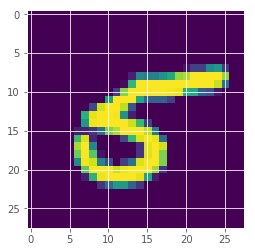

In [8]:
plt.imshow(ds.X[0].reshape((28, 28)))

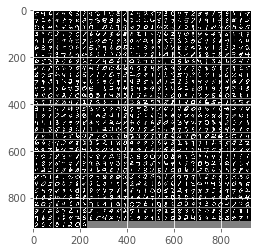

In [9]:
# Let's get the first 1000 images of the dataset and reshape them
imgs = ds.X[:1000].reshape((-1, 28, 28))

# Then create a montage and draw the montage
plt.imshow(montage(imgs), cmap='gray')

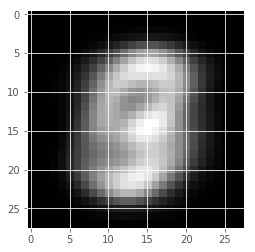

In [10]:
# Take the mean across all images
mean_img = np.mean(ds.X, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

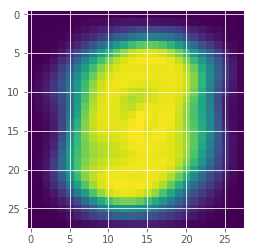

In [11]:
# Take the std across all images
std_img = np.std(ds.X, axis=0)

# Then plot the std image.
plt.figure()
plt.imshow(std_img.reshape((28, 28)))

### Fully Connected Model

from the original 784 neurons, we're going to slowly reduce that information down to smaller and smaller numbers. It's often standard practice to use other powers of 2 or 10. I'll create a list of the number of dimensions we'll use for each new layer.

In [13]:
dimensions = [512, 256, 128, 64]

So we're going to reduce our 784 dimensions down to 512 by multiplyling them by a 784 x 512 dimensional matrix. Then we'll do the same thing again using a 512 x 256 dimensional matrix, to reduce our dimensions down to 256 dimensions, and then again to 128 dimensions, then finally to 64.

We're first going to create placeholders for our tensorflow graph.

 We're going to pass our entire dataset in minibatches. So we'll send 100 images at a time. But we'd also like to be able to send in only 1 image and see what the prediction of the network is. That's why we let this dimension be flexible in the graph.

In [14]:

# So the number of features is the second dimension of our inputs matrix, 784
n_features = ds.X.shape[1]

# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

Now we're going to create a network which will perform a series of multiplications on X, followed by adding a bias, and then wrapping all of this in a non-linearity:

In [16]:
# let's first copy our X placeholder to the name current_input
current_input = X
n_input = n_features

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

So now we've created a series of multiplications in our graph which take us from our input of batch size times number of features which started as None x 784, and then we're multiplying it by a series of matrices which will change the size down to None x 64.

In [17]:
print(current_input.get_shape())

(?, 64)


In order to get back to the original dimensions of the image, we're going to reverse everything we just did. Let's see how we do that:

In [18]:
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

[128, 256, 512, 784]


In [19]:
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

After this, our current_input will become the output of the network:

In [20]:
Y = current_input

In [21]:
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [22]:
cost = tf.reduce_mean(cost)

We'll need to create an optimizer which takes a parameter learning_rate. And we tell it that we want to minimize our cost, which is measuring the difference between the output of the network and the input.

In [23]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [24]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we'll train:

0 0.0418624
1 0.0385483
2 0.0350312
3 0.0323778
4 0.0308942


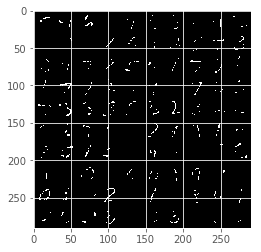

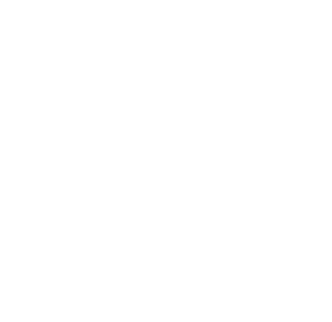

In [25]:
# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [26]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

## Convolutional Autoencoder

We're going to see how we can use many convolutional filters, way more than 1, and how it will help us to encode the MNIST dataset.


To begin we'll need to reset the current graph and start over.

In [28]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [29]:
# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

Since X is currently [batch, height*width], we need to reshape it to a 4-D tensor to use it in a convolutional graph. Remember back to the first session that in order to perform convolution, we have to use 4-dimensional tensors describing the:


N x H x W x C

We'll reshape our input placeholder by telling the shape parameter to be these new dimensions. However, since our batch dimension is None, we cannot reshape without using the special value -1, which says that the size of that dimension should be computed so that the total size remains constant. Since we haven't defined the batch dimension's shape yet, we use -1 to denote this dimension should not change size.

In [30]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

We'll now setup the first convolutional layer.The weight matrix for convolution should be


[height x width x input_channels x output_channels]


Now with our tensor ready, we're going to do what we've just done with the fully connected autoencoder. Except, instead of performing matrix multiplications, we're going to create convolution operations. To do that, we'll need to decide on a few parameters including the filter size, how many convolution filters we want, and how many layers we want. I'll start with a fairly small network, and let you scale this up in your own time.

In [31]:
n_filters = [16, 16, 16]
filter_sizes = [4, 4, 4]

In [32]:
current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

Now with our convolutional encoder built and the encoding weights stored, we'll reverse the whole process to decode everything back out to the original image.

In [33]:
# We'll first reverse the order of our weight matrices
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [35]:
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

Now we have the reconstruction through the network:

In [36]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

0 0.026093
1 0.0250973
2 0.0245274
3 0.0238625
4 0.0246458


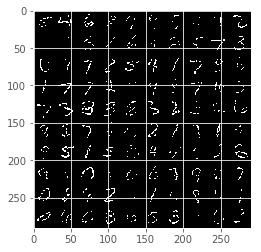

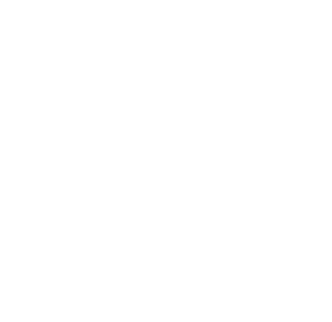

In [37]:

cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001

# pass learning rate and cost to optimize
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Session to manage vars/train
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [38]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

Here we got very accurate performance with cnn autoencoders rather than simple(vanila) autoencoders